## Predicting Churn

Here I try to train a model on a sub-section of the data to predict customer churn. I will fit different classifiers, such <code>DecisionTreeClassifier</code> and <code>LogisticRegression</code>, and compare the results by making predictions using unseen data.

Furthermore, analysis of the data showed that the targer variable is not balanced. I will adress this by integrating a <code>RandomUnderSampler</code> into my modelling.

In [1]:
#loading the necessary python libraries
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(font_scale = 1.5)

import matplotlib.pyplot as plt
import scikitplot as skplt
from matplotlib.colors import ListedColormap
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

In [2]:
#loading various libraries needed for preprocessing, modelling and evaluating
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from sklearn.metrics import recall_score, precision_score, make_scorer, fbeta_score

In [3]:
#loading the dataset into a pandas dataframe
customer_data = pd.read_csv('../data-sources/customer-churn/customer-churn.csv')
customer_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
#applying the same naming convention to all column names
customer_data.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender', 'tenure': 'Tenure'}, inplace=True)

In [5]:
#creating a function to convert numerical binary data into categorical binary data
def ColumnTransformer(cell):
    if cell == 0:
        return 'No'
    else:
        return 'Yes'

#applying the above function to the SeniorCitizen column
customer_data['SeniorCitizen'] = customer_data['SeniorCitizen'].apply(ColumnTransformer)

In [6]:
#creating a function to shorten the vocabulary for easier visualisation
def ColumnTransformer(cell):
    if cell == 'Electronic check':
        return 'ElCh'
    elif cell == 'Mailed check':
        return 'MaCh'
    elif cell == 'Bank transfer (automatic)':
        return 'BaTr-A'
    else:
        return 'CrCa-A'
    
#applying the above function to the PaymentMethod column
customer_data['PaymentMethod'] = customer_data['PaymentMethod'].apply(ColumnTransformer)

In [7]:
#removing all the customers who have been with the company for less than a month and deleting the CustomerID column
customer_data.drop(customer_data[customer_data['Tenure'] == 0].index, inplace=True)
customer_data.drop('CustomerID', axis=1, inplace=True)

#converting TotalCharges from object to float data type
customer_data['TotalCharges'] = customer_data['TotalCharges'].astype(float)

In [8]:
#separating the target variable
y = customer_data.pop('Churn')

In [9]:
#separating the predictor variables
X = customer_data

In [10]:
#dummifying the categorical features and removing any redundencies
X_dum = pd.get_dummies(X, columns=X.select_dtypes(include='object').columns, drop_first=True)

In [11]:
#splitting the data into different train and test sets and using the target variable for stratification
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.3, random_state=1, stratify=y)

In [12]:
#creating a StandardScaler object
scaler = StandardScaler()

#standardising the train and test feature sets
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

Churn models are often evaluated based on F1-beta score, as it is important to strike the right balance between the minimising the loss of revenue due to customer churn and minimising the cost of unnecessary promotions. This is done by chosing a beta based on the cost associated with each of these metrics. Here, I have decided to give recall more weight because the loss of revenue due to customer churn usually outweighs the loss due to false promotions.

In [14]:
#creating a custom scorer to use during hyperparameter optimisation
cust_scorer = make_scorer(fbeta_score, beta=0.85, pos_label='Yes')

#### Decision Tree Classifier

In [15]:
#creating a pipeline to automate under-sampling and modelling, and help with evaluation
pipe_dt = make_pipeline(RandomUnderSampler(random_state=1),
                        DecisionTreeClassifier(random_state=1))

#setting up the optimisation parameters
pipe_dt_params = {'decisiontreeclassifier__criterion': ['gini', 'entropy'],
                  'decisiontreeclassifier__max_depth': [5, 10, None],
                  'decisiontreeclassifier__min_samples_split': [2, 5, 9],
                  'decisiontreeclassifier__max_features': [0.3, 0.6, None, 'auto', 'log2']}

#creating a GridSearchCV opject and fitting it to the train set
pipe_dt_gs = GridSearchCV(pipe_dt, pipe_dt_params, cv=5, scoring=cust_scorer, n_jobs=-4, verbose=1)
pipe_dt_gs.fit(X_train, y_train)

#printing out the optimised parameters and the score achieved using those parameters
print('Best parameters:', pipe_dt_gs.best_params_)
print('Mean cross-validated F1-beta score:', pipe_dt_gs.best_score_)
print('Test F1-beta score:', pipe_dt_gs.score(X_test, y_test))

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__max_features': 0.3, 'decisiontreeclassifier__min_samples_split': 9}
Mean cross-validated F1-beta score: 0.5976684150983
Test F1-beta score: 0.6032816132234666


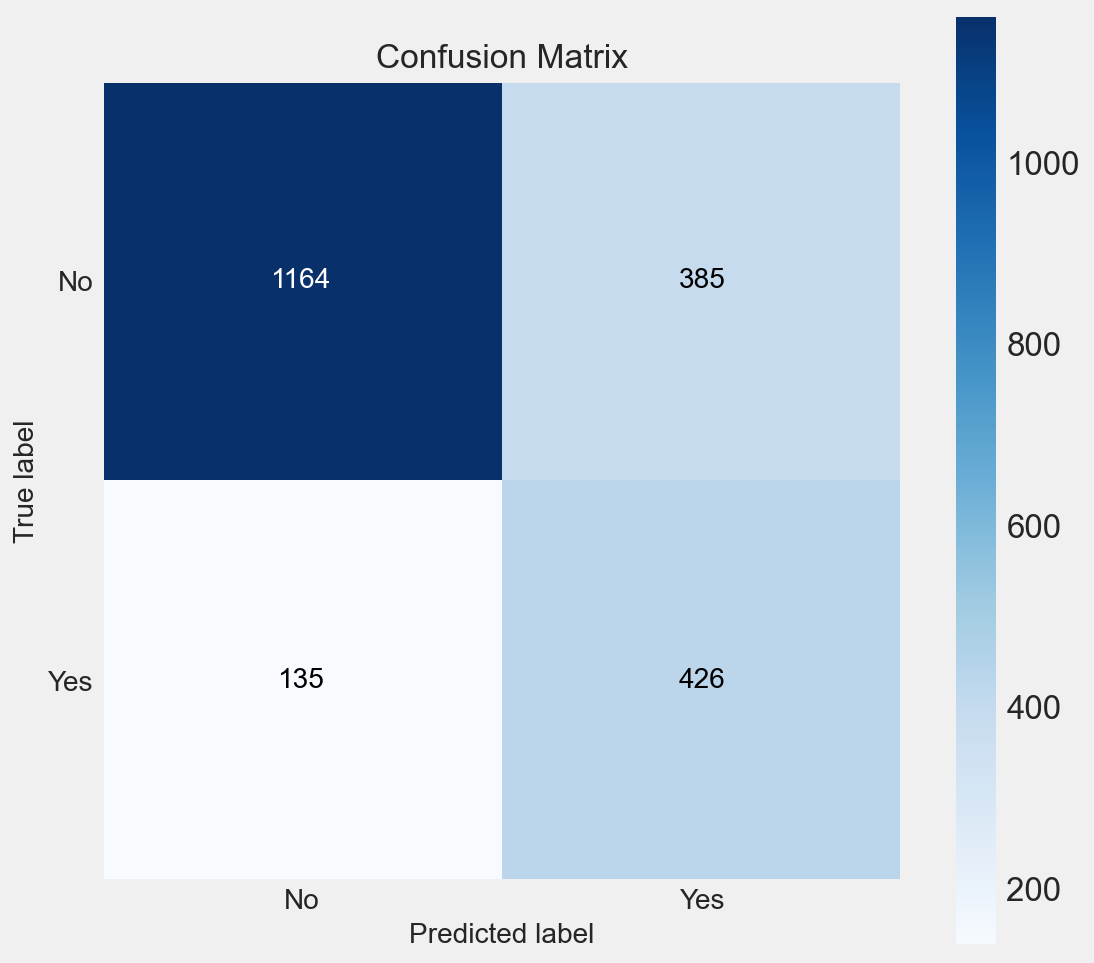

In [16]:
#making predictions and plotting the confusion matrix
dt_predictions = pipe_dt_gs.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, dt_predictions, figsize=(8, 8))
plt.show()

#### Logistic Regression Classifier

In [17]:
#creating a pipeline to automate under-sampling and modelling, and help with evaluation
pipe_lr = make_pipeline(RandomUnderSampler(random_state=1),
                        LogisticRegression(max_iter=10000))

#setting up the optimisation parameters
pipe_lr_params = {'logisticregression__penalty': ['elasticnet'],
                  'logisticregression__C': [0.01, 0.05, 0.5, 1, 10, 100],
                  'logisticregression__l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.9, 0.99],
                  'logisticregression__solver': ['saga'],
                  'logisticregression__fit_intercept': [True, False]}

#creating a GridSearchCV opject and fitting it to the train set
pipe_lr_gs = GridSearchCV(pipe_lr, pipe_lr_params, cv=5, scoring=cust_scorer, n_jobs=-4, verbose=1)
pipe_lr_gs.fit(X_train, y_train)

#printing out the optimised parameters and the score achieved using those parameters
print('Best parameters:', pipe_lr_gs.best_params_)
print('Mean cross-validated F1-beta score:', pipe_lr_gs.best_score_)
print('Test F1-beta score:', pipe_lr_gs.score(X_test, y_test))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'logisticregression__C': 0.5, 'logisticregression__fit_intercept': True, 'logisticregression__l1_ratio': 0.001, 'logisticregression__penalty': 'elasticnet', 'logisticregression__solver': 'saga'}
Mean cross-validated F1-beta score: 0.6080092429694046
Test F1-beta score: 0.5890257795435028


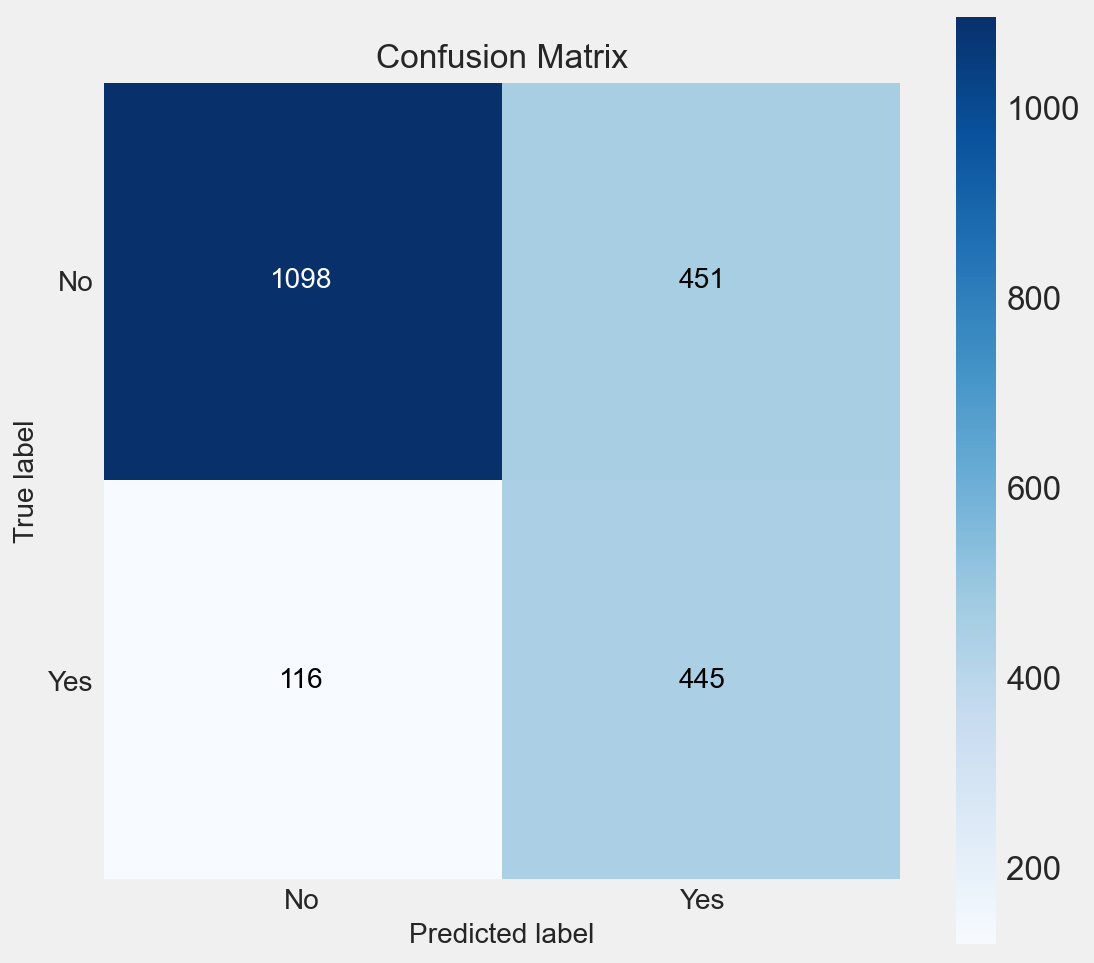

In [18]:
#making predictions and plotting the confusion matrix
lr_predictions = pipe_lr_gs.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, lr_predictions, figsize=(8, 8))
plt.show()

#### K-Neighbors Classifier

In [19]:
#creating a pipeline to automate under-sampling and modelling, and help with evaluation
pipe_knn = make_pipeline(RandomUnderSampler(random_state=1),
                         KNeighborsClassifier())

#setting up the optimisation parameters
pipe_knn_params = {'kneighborsclassifier__n_neighbors': [5, 10, 15, 20, 25],
                   'kneighborsclassifier__metric': ['manhattan', 'euclidean', 'cosine'],
                   'kneighborsclassifier__weights': ['uniform', 'distance']}

#creating a GridSearchCV opject and fitting it to the train set
pipe_knn_gs = GridSearchCV(pipe_knn, pipe_knn_params, cv=5, scoring=cust_scorer, n_jobs=28, verbose=1)
pipe_knn_gs.fit(X_train, y_train)

#printing out the optimised parameters and the score achieved using those parameters
print('Best parameters:', pipe_knn_gs.best_params_)
print('Mean cross-validated score:', pipe_knn_gs.best_score_)
print('Test score:', pipe_knn_gs.score(X_test, y_test))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'kneighborsclassifier__metric': 'cosine', 'kneighborsclassifier__n_neighbors': 20, 'kneighborsclassifier__weights': 'uniform'}
Mean cross-validated score: 0.5826341367594063
Test score: 0.5538453369075803


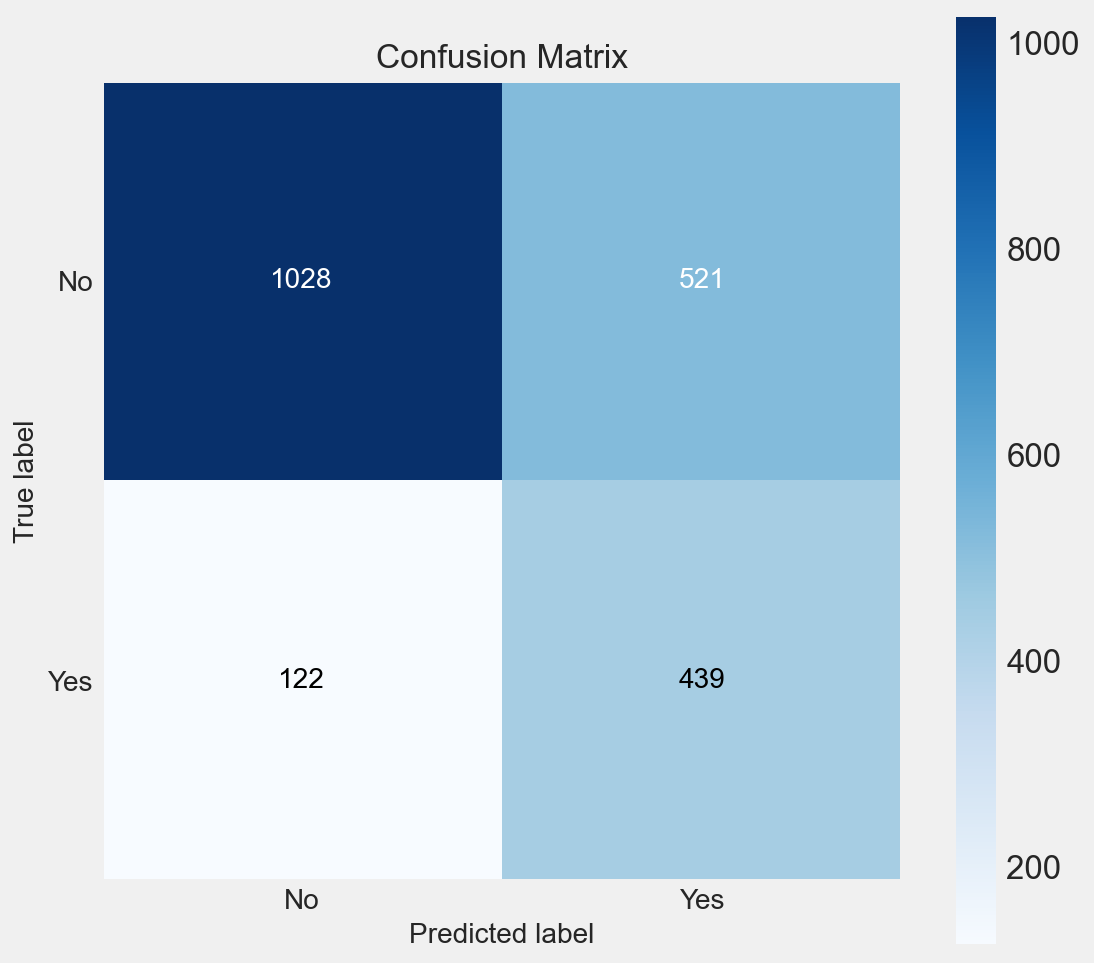

In [20]:
#making predictions and plotting the confusion matrix
knn_predictions = pipe_knn_gs.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, knn_predictions, figsize=(8, 8))
plt.show()

#### Random Forest Classifier

In [21]:
#creating a pipeline to automate under-sampling and modelling, and help with evaluation
pipe_rf = make_pipeline(RandomUnderSampler(random_state=1),
                        RandomForestClassifier(random_state=1))

#setting up the optimisation parameters
pipe_rf_params = {'randomforestclassifier__criterion': ['gini', 'entropy'],
                  'randomforestclassifier__max_depth': [5, 10, None],
                  'randomforestclassifier__max_features': [0.3, 0.6, 'auto'],
                  'randomforestclassifier__max_samples': [0.5, 0.8, None],
                  'randomforestclassifier__n_estimators': [30, 80, 130, 180, 230]} 

#creating a GridSearchCV opject and fitting it to the train set
pipe_rf_gs = GridSearchCV(pipe_rf, pipe_rf_params, cv=5, scoring=cust_scorer, n_jobs=28, verbose=1)
pipe_rf_gs.fit(X_train, y_train)

#printing out the optimised parameters and the score achieved using those parameters
print('Best parameters:', pipe_rf_gs.best_params_)
print('Mean cross-validated F1-beta score:', pipe_rf_gs.best_score_)
print('Test F1-beta score:', pipe_rf_gs.score(X_test, y_test))

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best parameters: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__max_samples': 0.5, 'randomforestclassifier__n_estimators': 80}
Mean cross-validated score: 0.6088767150727448
Test score: 0.5899847707824363


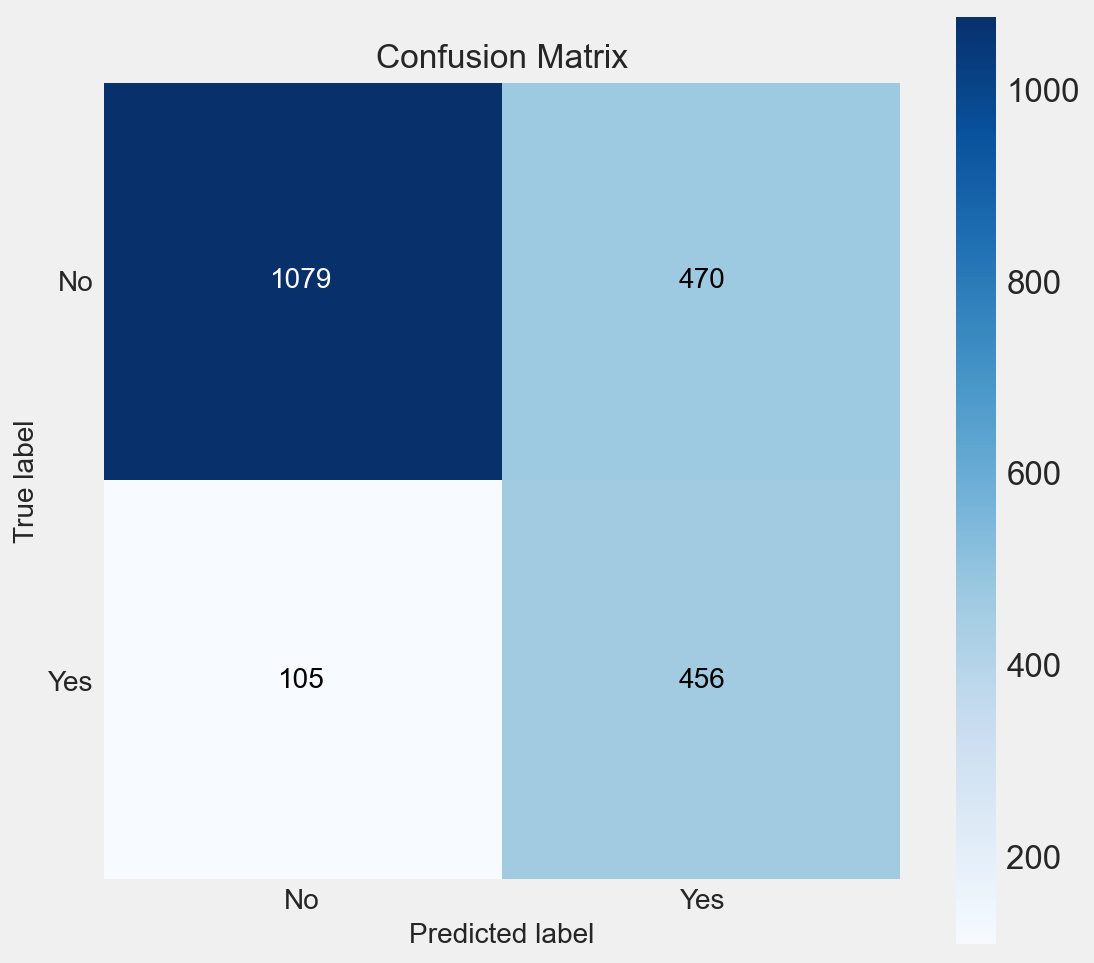

In [22]:
#making predictions and plotting the confusion matrix
rf_predictions = pipe_rf_gs.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, rf_predictions, figsize=(8, 8))
plt.show()

#### Voting Classifier

In [23]:
#setting up the base estimators
dt = DecisionTreeClassifier(random_state=1)
lr = LogisticRegression(max_iter=10000, solver='saga')

#creating a pipeline to automate under-sampling and modelling, and help with evaluation
pipe_vc = make_pipeline(RandomUnderSampler(random_state=1),
                        VotingClassifier([('dt', dt), ('lr', lr)]))

#setting up the optimisation parameters
pipe_vc_params = {'votingclassifier__voting': ['soft', 'hard'],
                  'votingclassifier__dt__criterion': ['gini', 'entropy'],
                  'votingclassifier__dt__max_depth': [5, 10, None],
                  'votingclassifier__dt__min_samples_split': [2, 5, 9],
                  'votingclassifier__dt__max_features': [None, 'auto', 'log2'],
                  'votingclassifier__lr__penalty': ['elasticnet'],
                  'votingclassifier__lr__C': [0.01, 0.05, 0.5, 1, 10, 100],
                  'votingclassifier__lr__l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.9, 0.99],
                  'votingclassifier__lr__fit_intercept': [True, False]}

#creating a GridSearchCV opject and fitting it to the train set
pipe_vc_gs = GridSearchCV(pipe_vc, pipe_vc_params, cv=5, scoring=cust_scorer, n_jobs=28, verbose=1)
pipe_vc_gs.fit(X_train, y_train)

#printing out the optimised parameters and the score achieved using those parameters
print('Best parameters:', pipe_vc_gs.best_params_)
print('Mean cross-validated F1-beta score:', pipe_vc_gs.best_score_)
print('Test F1-beta score:', pipe_vc_gs.score(X_test, y_test))

Fitting 5 folds for each of 7776 candidates, totalling 38880 fits


KeyboardInterrupt: 

In [ ]:
#making predictions and plotting the confusion matrix
vc_predictions = pipe_vc_gs.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, vc_predictions, figsize=(8, 8))
plt.show()

In [28]:
base_estimator_dt = DecisionTreeClassifier(max_depth=3, max_features=0.3)

pipe_abc = make_pipeline(RandomUnderSampler(random_state=1),
                         AdaBoostClassifier(base_estimator_dt, n_estimators=100, random_state=1))
pipe_abc.fit(X_train, y_train)

print('Mean cross-validated score:',
          cross_val_score(pipe_abc, X_train, y_train, cv=5, scoring=cust_scorer, n_jobs=28, verbose=1).mean())

abc_predictions = pipe_abc.predict(X_test)
print('Test score:', recall_score(y_test, abc_predictions, pos_label='Yes'))

[Parallel(n_jobs=28)]: Using backend LokyBackend with 28 concurrent workers.


Mean cross-validated score: 0.7239361235412828
Test score: 0.7450980392156863


[Parallel(n_jobs=28)]: Done   5 out of   5 | elapsed:    0.3s finished


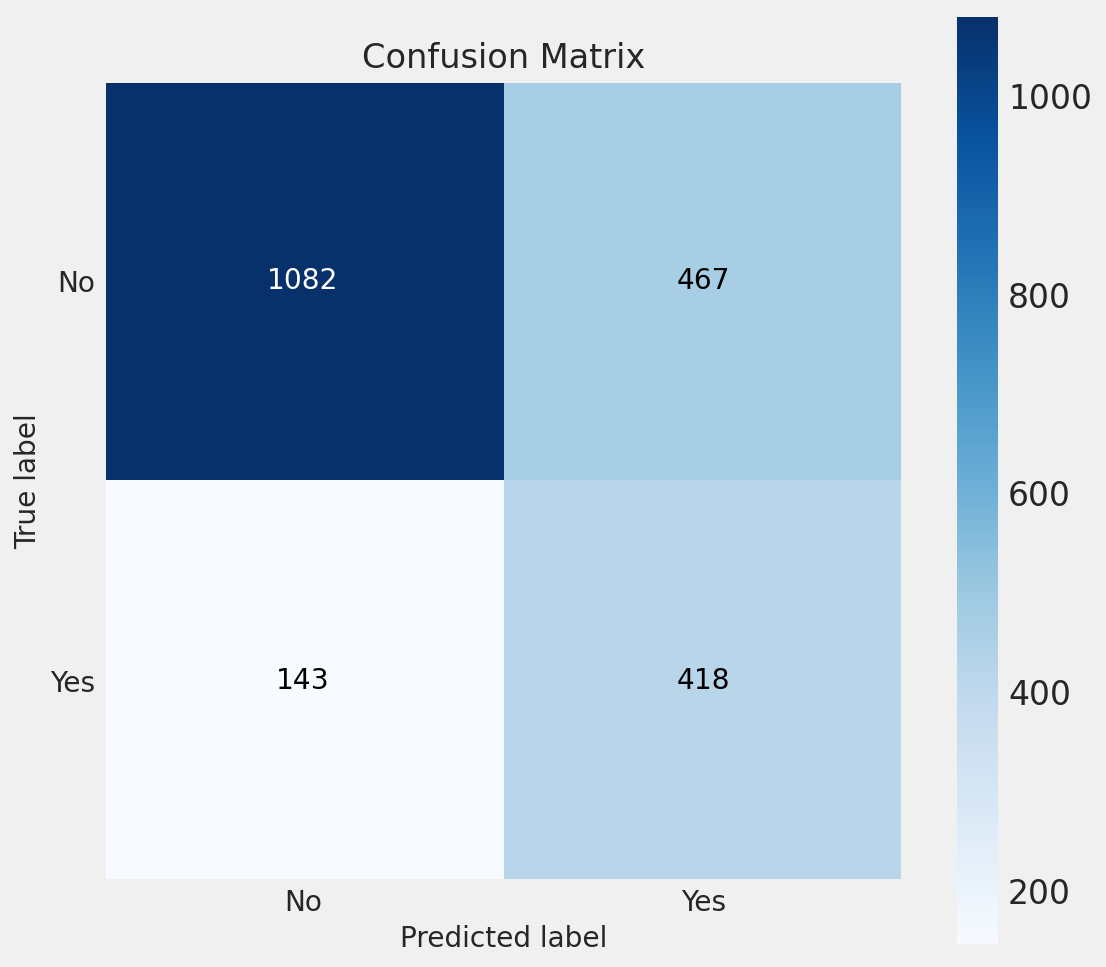

In [29]:
skplt.metrics.plot_confusion_matrix(y_test, abc_predictions, figsize=(8, 8))
plt.show()

In [30]:
base_estimator_rf = RandomForestClassifier(max_depth=3, max_features=0.3)

pipe_abc_rf = make_pipeline(RandomUnderSampler(random_state=1),
                            AdaBoostClassifier(base_estimator_rf, n_estimators=100, random_state=1))
pipe_abc_rf.fit(X_train, y_train)

print('Mean cross-validated score:',
      cross_val_score(pipe_abc_rf, X_train, y_train, cv=5, scoring=cust_scorer, n_jobs=28, verbose=1).mean())

abc_rf_predictions = pipe_abc_rf.predict(X_test)
print('Test score:', recall_score(y_test, abc_rf_predictions, pos_label='Yes'))

[Parallel(n_jobs=28)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done   5 out of   5 | elapsed:   13.2s finished


Mean cross-validated score: 0.7751776783364044
Test score: 0.7522281639928698


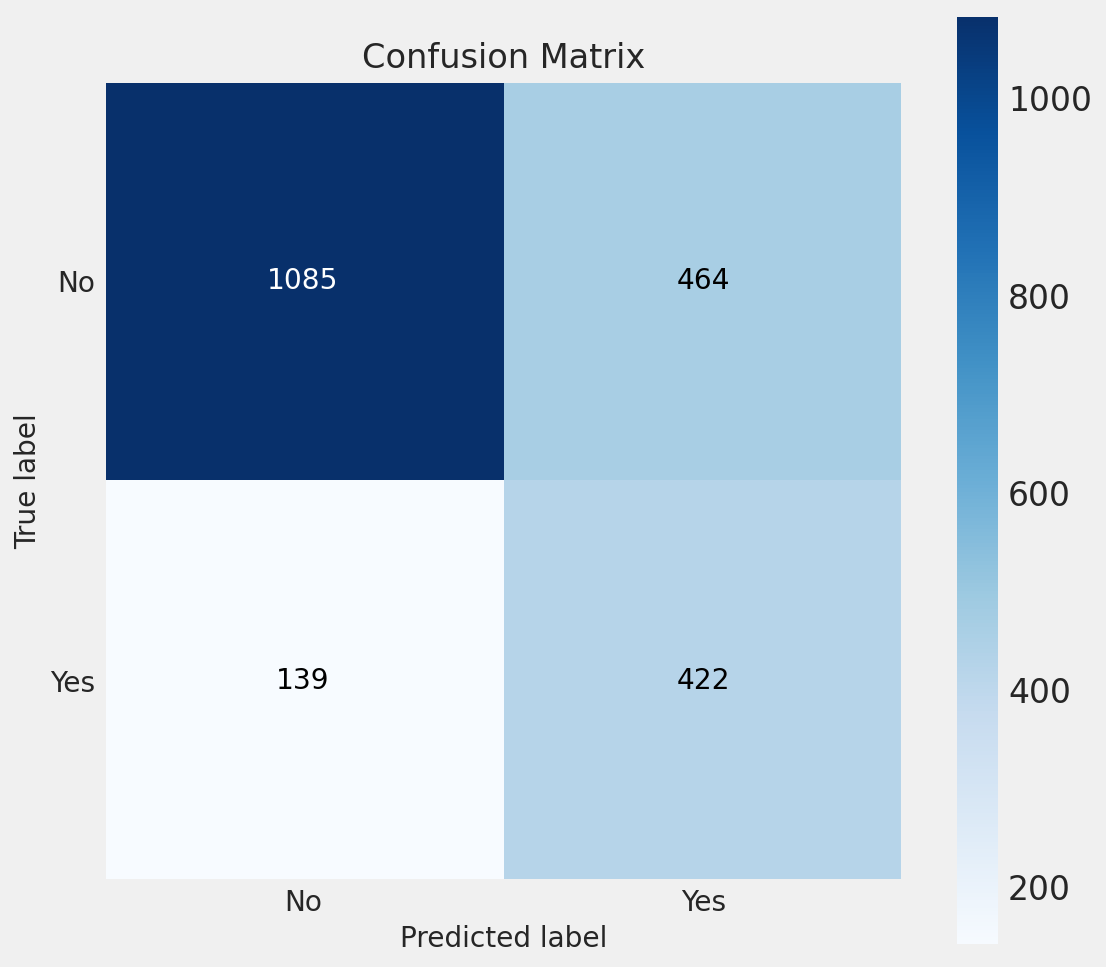

In [31]:
skplt.metrics.plot_confusion_matrix(y_test, abc_rf_predictions, figsize=(8, 8))
plt.show()